### This is 'Jigsaw Unintended Bias in Toxicity Classification' problem from Kaggle competitions

###### Firstly I have imported the necessary libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # ploting
import seaborn as sns # ploting 

from keras.models import Model # deep learning framework keras
from keras.layers import Dense, Embedding, Input, LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['train.csv', 'sample_submission.csv', 'test.csv']


## Reading csv files

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sub = pd.read_csv('../input/sample_submission.csv')

In [3]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


In [4]:
test.head()

,id,comment_text
0,7000000,Jeff Sessions is another one of Trump's Orwell...
1,7000001,I actually inspected the infrastructure on Gra...
2,7000002,No it won't . That's just wishful thinking on ...
3,7000003,Instead of wringing our hands and nibbling the...
4,7000004,how many of you commenters have garbage piled ...


#### There are 45 columns in training set and 2 columns in the test set and the number of rows in training set is 1804874 and no. of rows in test set is 97320.

In [5]:
train.shape, test.shape

((1804874, 45), (97320, 2))

#####  Length of each rows has been calculated. Maximum length is 1906. Also by plotting the table I have seen that the 75% data's row length is less then 420.

In [6]:
train_len = train.comment_text.apply(len)
train_len.head()
max(train_len)

1906

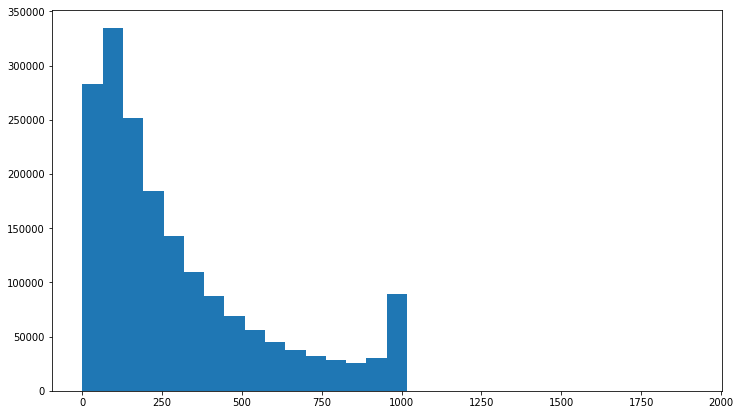

In [7]:
plt.figure(figsize = (12, 7))
plt.hist(train_len, bins = 30)
plt.show()

In [8]:
## almost data is in < len(400)
print("max-length :", np.max(train_len))
print("min-length :", np.min(train_len))
print("mean length :", np.mean(train_len))
print("75 perc :", np.percentile(train_len, 75))
print("std dev length :", np.std(train_len))

max-length : 1906
min-length : 1
mean length : 297.2343266067327
75 perc : 414.0
std dev length : 269.1965653836602


##### I have splitted the comment_test column's sentences into individual words and then visualized the length of the rows. Hightest number of words in a row was 317. Also the 75% data have words less then 72.

In [9]:
train_len = train.comment_text.apply(lambda x : len(x.split()))
train_len.head()
max(train_len)

317

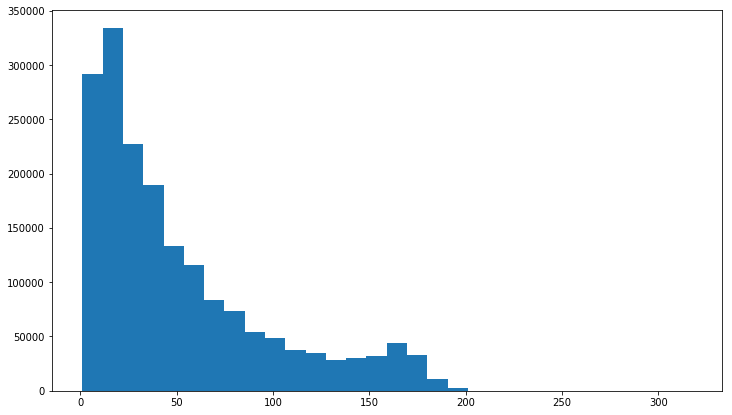

In [10]:
plt.figure(figsize = (12, 7))
plt.hist(train_len, bins = 30)
plt.show()

In [11]:
print("max length :", np.max(train_len))
print("min length :", np.min(train_len))
print("mean length :", np.mean(train_len))
print("75 % percentile :", np.percentile(train_len, 75))
print("std dev length :", np.std(train_len))

max length : 317
min length : 1
mean length : 51.276896337362054
75 % percentile : 72.0
std dev length : 46.17810121834347


In [12]:
X_train = train['comment_text'].astype(str)
test1 = test['comment_text'].astype(str)

##### Here is some visualization of the words appearing more times are larger

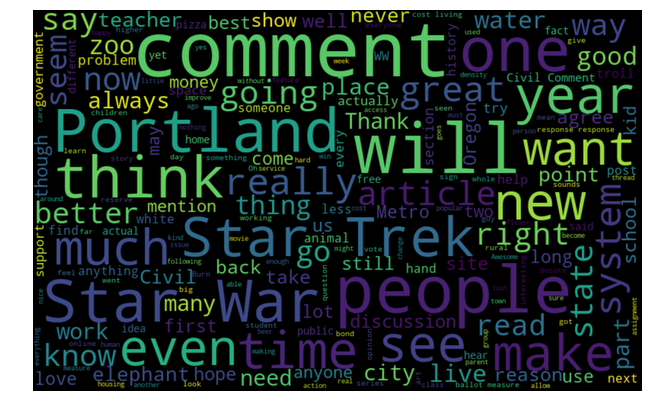

In [13]:
temp = X_train[0]
for i in range(len(X_train)):
    temp = temp + X_train[i]

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(temp[0:100000])

plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation="bessel")
plt.axis('off')
plt.show()

#### Here I have change the value of target probabilities into 0 and 1

In [14]:
y = np.where(train['target'] >= 0.5, True, False) * 1

In [15]:
y

array([0, 0, 0, ..., 0, 1, 0])

### Text Preprocessing

* **Tokenizer** - This helps to vectorize the text corpus. num_words is the total number of words we want to keep.
* **Fit on texts** - I have used it to update the *internal vocabulary* based on the list of texts.
  For example :- word_index["like"] = 0; word_index["comment"] = 1
* **Text to sequences** - Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary. 
* **Pad Sequences** - Pad sequences is used to ensure that all sequences in a list have the same length.

In [16]:
num_words = 15000
max_len = 120
emb_size = 128

In [17]:
tok = Tokenizer(num_words = 15000)
tok.fit_on_texts(list(X_train))

In [18]:
X = tok.texts_to_sequences(X_train)
test = tok.texts_to_sequences(test1)

In [19]:
X = sequence.pad_sequences(X, maxlen = max_len)
test1 = sequence.pad_sequences(test, maxlen = max_len)

In [20]:
X.shape, test1.shape

((1804874, 120), (97320, 120))

In [21]:
### now, make model! with LSTM, Bidirectional

## Model

* **Embedding** - The Embedding layer is initialized with random weights and will learn an embedding for all of the words in the training dataset.
* **Bidirectional(lstm)** - Bidirectional LSTMs train two instead of one LSTMs on the input sequence. So, It can work in less time then encoder-decoder model.
* **Compile** Compile defines the loss function, the optimizer and the metrics.
* **Fitting** Fitting the model on 80% training set and validating it on 20%.

In [22]:
inp = Input(shape = (max_len, ))
layer = Embedding(num_words, emb_size)(inp)
layer = Bidirectional(LSTM(50, return_sequences = True, recurrent_dropout = 0.15))(layer)
layer = GlobalMaxPool1D()(layer)
layer = Dropout(0.2)(layer)
layer = Dense(50, activation = 'relu')(layer)
layer = Dropout(0.2)(layer)
layer = Dense(1, activation = 'sigmoid')(layer)
model = Model(inputs = inp, outputs = layer)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 120)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 120, 128)          1920000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 120, 100)          71600     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
__________

In [24]:
history = model.fit(X, y, batch_size = 1024, epochs = 2, validation_split = 0.2)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1443899 samples, validate on 360975 samples
Epoch 1/2
1443899/1443899 [==============================] - 763s 529us/step - loss: 0.1601 - acc: 0.9440 - val_loss: 0.1448 - val_acc: 0.9455
Epoch 2/2
1443899/1443899 [==============================] - 749s 519us/step - loss: 0.1332 - acc: 0.9504 - val_loss: 0.1423 - val_acc: 0.9460


#### Then I have plotted the training and validation loss

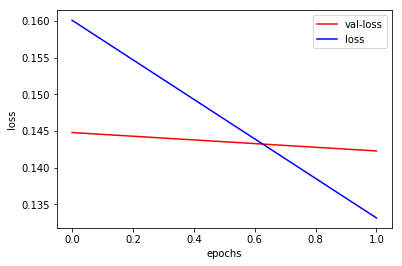

In [25]:
vloss = history.history['val_loss']
loss = history.history['loss']

x_len = np.arange(len(loss))

plt.plot(x_len, vloss, c='red', label='val-loss')
plt.plot(x_len, loss, c='blue', label='loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [26]:
y_test = model.predict(test1)

In [27]:
sub['prediction'] = y_test
sub.head()

,id,prediction
0,7000000,0.007540
1,7000001,0.001850
2,7000002,0.001580
3,7000003,0.002283
4,7000004,0.934210


In [28]:
sub.to_csv('submission.csv', index=False)